In [7]:
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
with open('imdb_movies_2000to2022.prolific.json', 'r') as f:
    imdb_data = [json.loads(line) for line in f]

In [9]:
imdb_rows = []
for entry in imdb_data:
    if "rating" in entry and "avg" in entry["rating"] and entry["rating"]["avg"] != "\\N":
        rating = float(entry["rating"]["avg"])
        year = int(entry["year"]) if entry["year"].isdigit() else None
        for actor in entry.get("actors", []):
            imdb_rows.append({
                "actor_name": actor[1],
                "rating": rating,
                "year": year
            })

df_imdb = pd.DataFrame(imdb_rows)

In [22]:
imdb_stats = df_imdb.groupby('actor_name').agg(
    avg_rating=('rating', 'mean'),
    movie_count=('rating', 'count'),
    first_year=('year', 'min'),
    last_year=('year', 'max')
).reset_index()
imdb_stats['years_active'] = imdb_stats['last_year'] - imdb_stats['first_year']

In [24]:
tmdb_movies = pd.read_csv('/Users/superjoetendo/Documents/actor-pairing-analysis/tmdb_5000_movies.csv')
tmdb_credits = pd.read_csv('//Users/superjoetendo/Documents/actor-pairing-analysis/tmdb_5000_credits.csv')

In [25]:
tmdb_credits['cast'] = tmdb_credits['cast'].apply(json.loads)
tmdb_cast_rows = []
for _, row in tmdb_credits.iterrows():
    for actor in row['cast']:
        tmdb_cast_rows.append({
            'movie_id': row['movie_id'],
            'actor_name': actor['name']
        })

df_cast = pd.DataFrame(tmdb_cast_rows)

In [26]:
tmdb_movies_subset = tmdb_movies[['id', 'popularity', 'revenue']]
df_tmdb = df_cast.merge(tmdb_movies_subset, left_on='movie_id', right_on='id', how='left')

In [27]:
tmdb_stats = df_tmdb.groupby('actor_name').agg(
    avg_popularity=('popularity', 'mean'),
    total_revenue=('revenue', 'sum')
).reset_index()

In [28]:
merged = imdb_stats.merge(tmdb_stats, on='actor_name', how='inner')
merged = merged[merged['movie_count'] >= 3].copy()

In [29]:
features = merged[['avg_rating', 'movie_count', 'avg_popularity', 'total_revenue']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [30]:
kmeans = KMeans(n_clusters=4, random_state=42)
merged['cluster'] = kmeans.fit_predict(X_scaled)

In [31]:
cluster_labels = {
    0: "Consistent Performers",
    1: "Up-and-Comers",
    2: "Veterans",
    3: "Critically Acclaimed"
}
merged['cluster_name'] = merged['cluster'].map(cluster_labels)

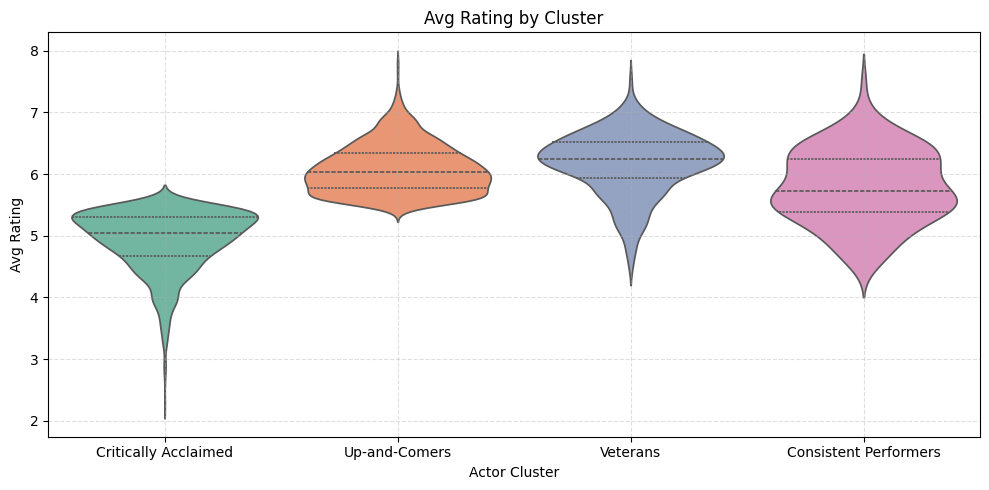

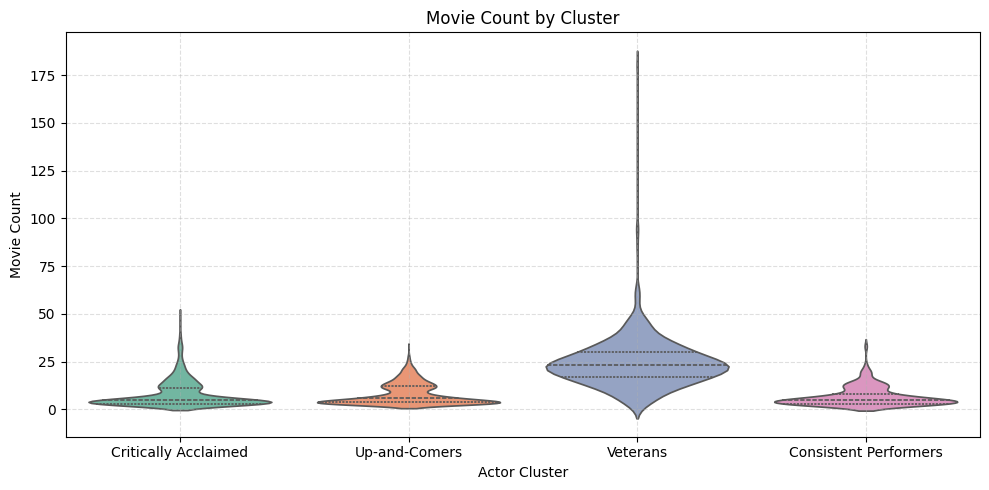

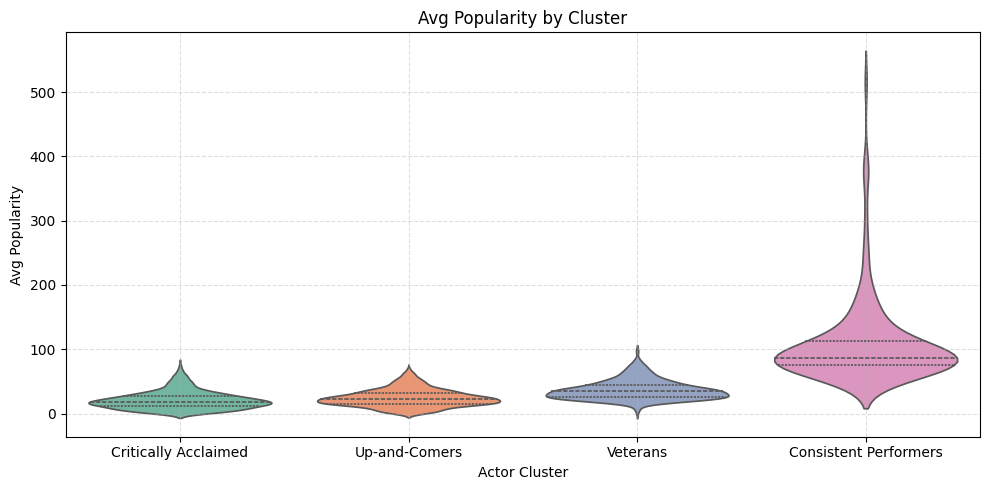

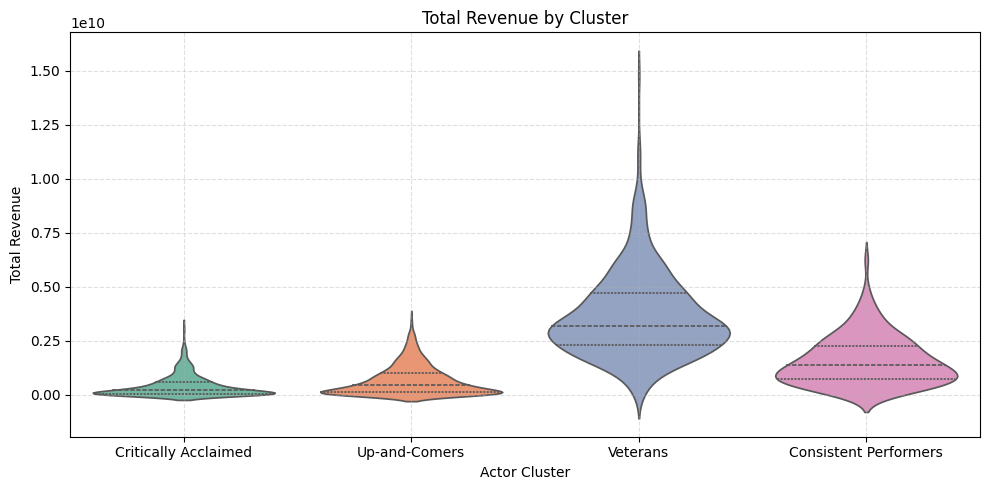

In [33]:
plot_features = ['avg_rating', 'movie_count', 'avg_popularity', 'total_revenue']
for feature in plot_features:
    plt.figure(figsize=(10, 5))
    sns.violinplot(data=merged, x='cluster_name', y=feature, hue='cluster_name', palette='Set2', inner='quartile', dodge=False)
    plt.title(f'{feature.replace("_", " ").title()} by Cluster')
    plt.xlabel('Actor Cluster')
    plt.ylabel(feature.replace("_", " ").title())
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [34]:
cluster_summary = merged.groupby('cluster_name').agg({
    'avg_rating': 'mean',
    'movie_count': 'mean',
    'avg_popularity': 'mean',
    'total_revenue': 'mean',
    'actor_name': 'count'
}).rename(columns={'actor_name': 'actor_count'})

display(cluster_summary)

,avg_rating,movie_count,avg_popularity,total_revenue,actor_count
cluster_name,,,,,
Consistent Performers,5.789942,6.811189,109.778052,1.569347e+09,143
Critically Acclaimed,4.925340,8.163738,21.084778,4.115193e+08,1252
Up-and-Comers,6.078801,8.008290,24.599250,6.677565e+08,1930
Veterans,6.172931,24.346457,37.053406,3.664400e+09,508
